Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]


--- ROI Attempt 1 ---


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


--- ROI Attempt 2 ---


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Saved: output_inpainted_cropped.jpg.
ROI: (591, 366, 612, 387)


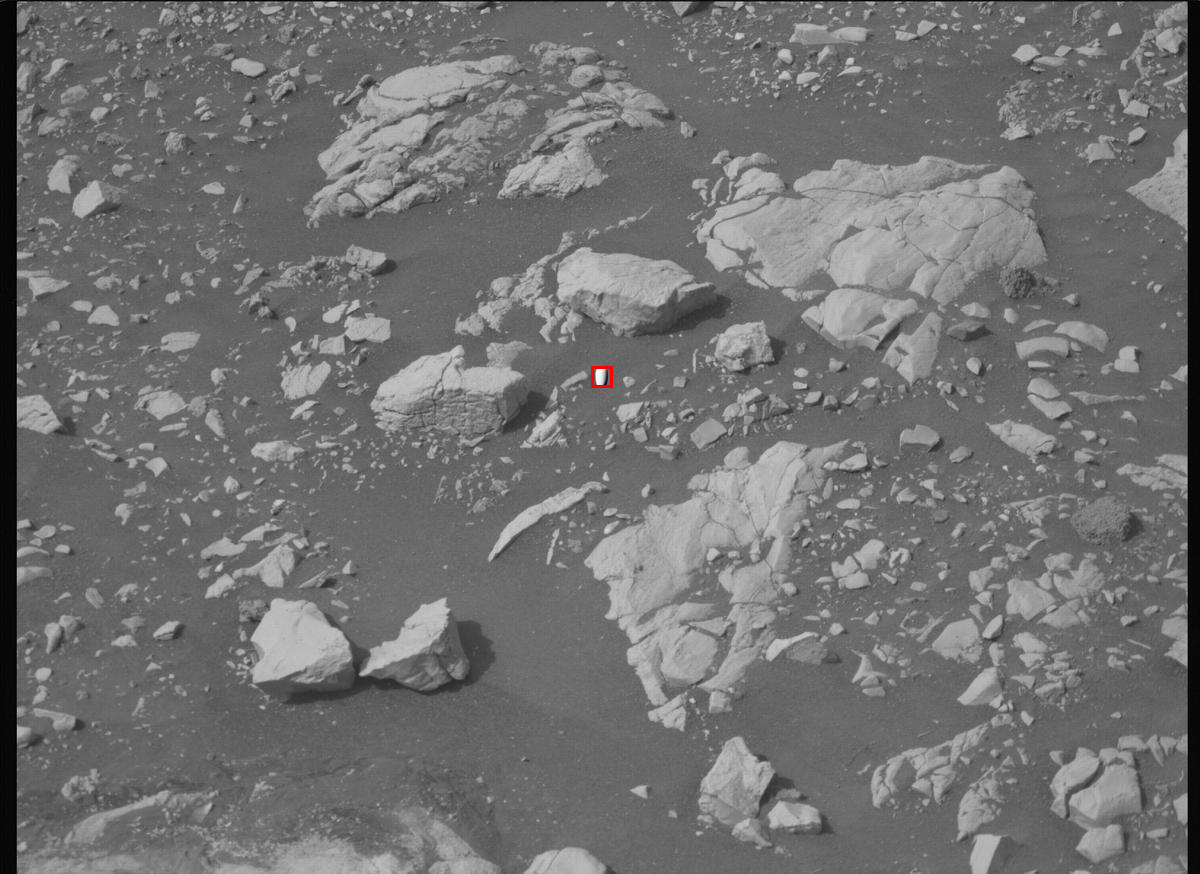

In [3]:
import random
import torch
import glob
import numpy as np
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image, ImageDraw

# Table of Acryonms:
# ROI: Region of Interest
# Inpainting: The process of generating new content on an image given a mask region

# Configs
diff_threshold = 35        # Mean grayscale difference threshold.
max_inpaint_attempts = 4   # Maximum inpainting tries per ROI.
max_roi_attempts = 5       # Maximum ROI re-selections if needed.
targets = [
"single metallic sphere floating, a perfectly uniform, solid metallic sphere with a smooth, mirror-like reflective surface and no visible textures or patterns",
"a smooth, white, capsule-shaped object with rounded edges and a clean, uniform surface"
]

# Variables
roi_found = False
roi_attempt = 0               # Count how many different ROIs have been tried.
last_inpainted_zoomed = None  # Save the last inpainted result.

# Selecting a random image
image_paths = glob.glob("mars_images/1200x874/*.jpg")
input_image_path = random.choice(image_paths)
original_image = Image.open(input_image_path).convert("RGB")
orig_width, orig_height = original_image.size

# Initialize the generator inpainting pipeline.
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16
).to("cuda")

# Loop for each generation. Only needed because the generator sometimes returns images that don't have any visiable inpainting.
while not roi_found and roi_attempt < max_roi_attempts:
    print(f"\n--- ROI Attempt {roi_attempt+1} ---")

    # 1. Randomly selecting a cropped region with varrying size within the image.
    possible_sizes = range(50, 100, 5)
    crop_size = random.choice(possible_sizes)
    crop_width, crop_height = crop_size, crop_size
    crop_left = random.randint(0, orig_width - crop_width)
    crop_top = random.randint(0, orig_height - crop_height)
    crop_right = crop_left + crop_width
    crop_bottom = crop_top + crop_height
    cropped_region = original_image.crop((crop_left, crop_top, crop_right, crop_bottom))
    
    # 2. Cropped region is resized to 512×512 for the inpainting model.
    zoomed_size = (512, 512)
    zoomed_region = cropped_region.resize(zoomed_size, Image.LANCZOS)

    # 3. Mask is generated within the 512x512 inpainting model to allow for target to be drawn.
    mask = Image.new("L", zoomed_size, 0)
    mask_size = 120
    mask_center_x, mask_center_y = zoomed_size[0] // 2, zoomed_size[1] // 2
    mask_left   = mask_center_x - mask_size // 2
    mask_top    = mask_center_y - mask_size // 2
    mask_right  = mask_center_x + mask_size // 2
    mask_bottom = mask_center_y + mask_size // 2
    mask_draw = ImageDraw.Draw(mask)
    mask_draw.rectangle((mask_left, mask_top, mask_right, mask_bottom), fill=255)

    # 4. Target type is selected randomly
    prompt = random.choice(targets)

    # 5. Attempt inpainting up to max_inpaint_attempts for this ROI.
    for attempt in range(max_inpaint_attempts):

        # Running the inptaining pipeline and saving the result
        inpainted_zoomed = pipe( prompt=prompt, image=zoomed_region, mask_image=mask).images[0]
        last_inpainted_zoomed = inpainted_zoomed
        
        # Mean difference of the two cropped regions. This is to check if the inpainting model returned a drawn target.
        arr1 = np.array(zoomed_region.crop((mask_left, mask_top, mask_right, mask_bottom)).convert("L"), dtype=np.float32)
        arr2 = np.array(inpainted_zoomed.crop((mask_left, mask_top, mask_right, mask_bottom)).convert("L"), dtype=np.float32)
        diff = np.abs(arr1 - arr2)
        mean_diff = np.mean(diff)
        
        if mean_diff > diff_threshold:
            roi_found = True
            break
    
    if not roi_found:
        roi_attempt += 1

# Running remaining process on generated target
if roi_found:

    # Crop inpainted result to the masked region (center 120×120)
    cropped_inpainted = last_inpainted_zoomed.crop((mask_left, mask_top, mask_right, mask_bottom))

    # Resize the inpainted region back & paste into the original image.
    scale_factor = crop_width / zoomed_size[0]  # Ratio for resizing 512→crop_size.
    resized_masked = cropped_inpainted.resize(
        (int(mask_size * scale_factor), int(mask_size * scale_factor)),
        Image.LANCZOS
    )

    paste_x = (crop_width  // 2) - (resized_masked.width  // 2)
    paste_y = (crop_height // 2) - (resized_masked.height // 2)

    composite_crop = cropped_region.copy()
    composite_crop.paste(resized_masked, (paste_x, paste_y))

    final_image = original_image.copy()
    final_image.paste(composite_crop, (crop_left, crop_top))
    print("Saved: output_inpainted_cropped.jpg.")

    roi_left = crop_left + int(mask_left * scale_factor)
    roi_top = crop_top + int(mask_top * scale_factor)
    roi_right = roi_left + resized_masked.width
    roi_bottom = roi_top + resized_masked.height

    # Visualize by drawing a rectangle around the ROI.
    visualization_image = final_image.copy()
    draw = ImageDraw.Draw(visualization_image)
    print("ROI:", (roi_left, roi_top, roi_right, roi_bottom))
    draw.rectangle((roi_left, roi_top, roi_right, roi_bottom), outline="red", width=3)
    visualization_image.show()
